In [3]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"viktoriabenkova","key":"0e4fa7fb2884edd855c8804b44964e12"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [1]:
!rm -rf sample_data

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Data preparation

In this section we will download the dataset from kaggle, and prepare it for model.

Following 2 segments takes a lot of time to download and unzip due to big amount of data.

In [4]:
!kaggle competitions download -c landmark-recognition-2021

100% 97.7G/97.7G [1:13:03<00:00, 29.2MB/s]
100% 97.7G/97.7G [1:13:03<00:00, 23.9MB/s]


In [ ]:
file_name = "landmark-recognition-2021.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done!")

Done!


## Load data and analyze data

In [32]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [12]:
landmark_unique = len(train_df['landmark_id'].unique())
print(landmark_unique)

81313


We have 81 313 unique landmarks.

In [33]:
TRAIN_DIR = f'./train'

### Visualization of data classes and their counts

In [6]:
print(train_df['landmark_id'].value_counts())

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
84677        2
36989        2
133688       2
17316        2
111405       2
Name: landmark_id, Length: 81313, dtype: int64


In [30]:
freq_df=train_df.groupby('landmark_id').count()
freq_df['frequency']=freq_df['id']
landmark_df=freq_df.drop('id',axis=1)
sorted_df=freq_df.sort_values(by='frequency',ascending=False).reset_index()

From the most frequent...

In [31]:
head_df=sorted_df.head(50)
head_df['landmark_id'] =  head_df.landmark_id.apply(lambda x: f'landmark_{x}')

fig = px.bar(head_df, y="frequency", x="landmark_id",color='landmark_id', orientation='v',
             hover_data=["landmark_id", "frequency"])
fig.show()

<ipython-input-31-1797049fac82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_df['landmark_id'] =  head_df.landmark_id.apply(lambda x: f'landmark_{x}')


...to classes with only few examples.

In [32]:
head_df=sorted_df.tail(50)
head_df['landmark_id'] =  head_df.landmark_id.apply(lambda x: f'landmark_{x}')

fig = px.bar(head_df, y="frequency", x="landmark_id",color='landmark_id', orientation='v',
             hover_data=["landmark_id", "frequency"])
fig.show()

<ipython-input-32-d6b26fb5d473>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Add path to image in dataframe

In [34]:
train_df['path'] = (train_df['id'].apply(lambda r: os.path.join
                            (TRAIN_DIR, r[0], r[1], r[2], r + '.jpg')))

In [5]:
train_df.head()

,id,landmark_id,path
0,17660ef415d37059,1,./train/1/7/6/17660ef415d37059.jpg
1,92b6290d571448f6,1,./train/9/2/b/92b6290d571448f6.jpg
2,cd41bf948edc0340,1,./train/c/d/4/cd41bf948edc0340.jpg
3,fb09f1e98c6d2f70,1,./train/f/b/0/fb09f1e98c6d2f70.jpg
4,25c9dfc7ea69838d,7,./train/2/5/c/25c9dfc7ea69838d.jpg


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
 2   path         1580470 non-null  object
dtypes: int64(1), object(2)
memory usage: 36.2+ MB


### Image load and display

In [35]:
IMG_SIZE = 64

def img_load(img_path):
    img = plt.imread(img_path)
    img = img/255.
    img_redim = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_redim

In [9]:
def plot_images(landmark_id=12):
    landmark = train_df[train_df['landmark_id']==landmark_id].head(25)
    imgs = [img_load(x) for x in landmark['path']]
    _, axs = plt.subplots(5,5, figsize=(12, 12))
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(imgs, axs)):
        ax.title.set_text(str(landmark['id'].iloc[i]))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

Images of one class.

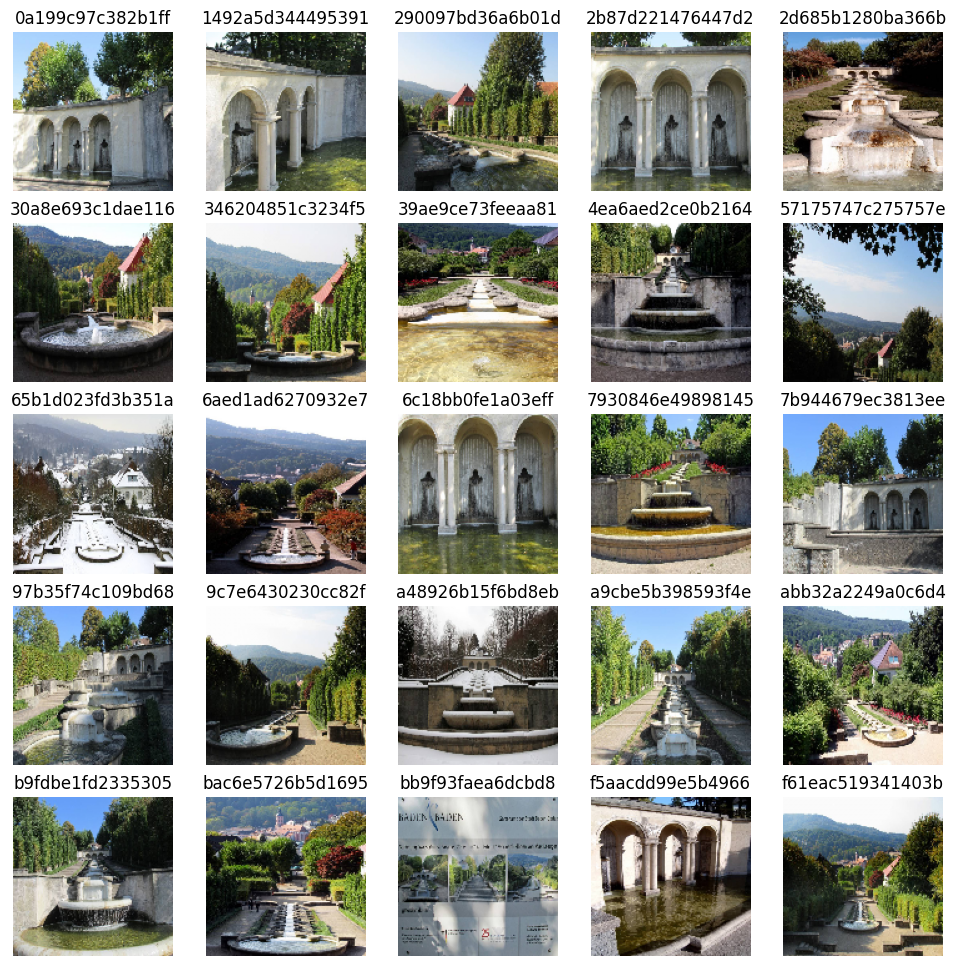

In [10]:
plot_images()

# Prepare smaller dataset

We drop those, which are outliers - either too many of them or too little.

In [36]:
sample = train_df['landmark_id'].value_counts()

In [37]:
to_remove_upper = sample[sample >= 1000].index

In [8]:
to_remove_upper

Int64Index([138982, 126637, 20409, 83144, 113209, 177870, 194914], dtype='int64')

In [38]:
to_remove_lower = sample[sample <= 500].index

In [10]:
to_remove_lower

Int64Index([ 19605,  28139, 132969, 115821, 147897,  73300, 107801,  80272,
             29794, 171683,
            ...
             84791,  84731, 133657,  84711,  84686,  84677,  36989, 133688,
             17316, 111405],
           dtype='int64', length=81262)

In [39]:
filtered_data = train_df[~train_df['landmark_id'].isin(to_remove_upper)]

In [40]:
filtered_data = filtered_data[~filtered_data['landmark_id'].isin(to_remove_lower)]

In [15]:
filtered_data['landmark_id'].value_counts()

149980    971
139894    966
1924      944
176528    920
9070      900
20120     888
168098    888
46705     888
161902    861
36748     839
176018    820
120734    820
10419     776
45428     757
14915     754
41648     742
165596    734
47378     731
187779    730
38482     704
40088     679
25093     663
162833    662
173511    656
189907    621
190822    614
76303     604
191292    600
109169    597
51856     576
192931    572
41808     570
107164    542
189811    540
101399    538
64792     531
80177     527
27190     520
152708    514
143710    508
31531     505
27        504
113838    503
85633     502
Name: landmark_id, dtype: int64

In [14]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30281 entries, 119 to 1503297
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           30281 non-null  object
 1   landmark_id  30281 non-null  int64 
 2   path         30281 non-null  object
dtypes: int64(1), object(2)
memory usage: 946.3+ KB


In [15]:
landmark_unique = len(filtered_data['landmark_id'].unique())
print(landmark_unique)

44


In [44]:
filtered_data.head()

,id,landmark_id,path
119,00cba0067c078490,27,./train/0/0/c/00cba0067c078490.jpg
120,00f928e383e1d121,27,./train/0/0/f/00f928e383e1d121.jpg
121,0110a04e618bc368,27,./train/0/1/1/0110a04e618bc368.jpg
122,026afdc670937e3b,27,./train/0/2/6/026afdc670937e3b.jpg
123,0319627771784e54,27,./train/0/3/1/0319627771784e54.jpg


In [16]:
len(filtered_data)

30281

In [17]:
filtered_data.to_csv("filtered_data.csv")

In [41]:
subset_df = filtered_data

In [42]:
del train_df
del filtered_data

Now we have approximately 30 000 pictures which each belongs to one of 44 labels.

### Encode data

In [43]:
encoder = LabelEncoder()
subset_df['label'] = encoder.fit_transform(subset_df['landmark_id'])
subset_df.head(10)

,id,landmark_id,path,label
119,00cba0067c078490,27,./train/0/0/c/00cba0067c078490.jpg,0
120,00f928e383e1d121,27,./train/0/0/f/00f928e383e1d121.jpg,0
121,0110a04e618bc368,27,./train/0/1/1/0110a04e618bc368.jpg,0
122,026afdc670937e3b,27,./train/0/2/6/026afdc670937e3b.jpg,0
123,0319627771784e54,27,./train/0/3/1/0319627771784e54.jpg,0
124,0362bd7cb1d405e6,27,./train/0/3/6/0362bd7cb1d405e6.jpg,0
125,038450020a8c3338,27,./train/0/3/8/038450020a8c3338.jpg,0
126,04104ac526aac788,27,./train/0/4/1/04104ac526aac788.jpg,0
127,043df08d08e77376,27,./train/0/4/3/043df08d08e77376.jpg,0
128,0494a4b4e535990b,27,./train/0/4/9/0494a4b4e535990b.jpg,0


In [48]:
print(len(subset_df['label'].unique()))

44


### Train, val and test data

In [44]:
y_prepared = []
X_prepared = []
subset_df.reset_index(inplace=True, drop=True)

# takes a long time
for i in range(subset_df.shape[0]):
    #print(i)
    X_prepared.append(img_load(subset_df['path'][i]))
    y_prepared.append(np.array(subset_df['label'][i]))

print("Done")

Done


In [45]:
X_prepared = np.array(X_prepared)
y_prepared = np.array(y_prepared)

In [16]:
train_X, val_X, train_y, val_y = train_test_split(X_prepared, y_prepared, test_size=0.2,random_state=40, shuffle=True)

In [17]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size = 0.05, random_state=40, shuffle=True)

In [18]:
# to clear the RAM
del X_prepared
del y_prepared

# Create and train model

In [19]:
from keras.applications import ResNet50

In [20]:
resnet = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet.trainable=True

94765736/94765736 [==============================] - 4s 0us/step


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=7,
                          verbose=1,
                          restore_best_weights=True
                          )
callbacks = [early_stopping]

In [22]:
model = tf.keras.Sequential()
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(44, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 44)                360492    
                                                                 
Total params: 23948204 (91.36 MB)
Trainable params: 23895084 (91.15 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [24]:
history = model.fit(train_X, train_y, epochs=5, batch_size=128, validation_data = (val_X, val_y), callbacks=callbacks)

Epoch 1/5
180/180 [==============================] - 3602s 20s/step - loss: 2.6943 - sparse_categorical_accuracy: 0.3758 - val_loss: 14.2327 - val_sparse_categorical_accuracy: 0.0272
Epoch 2/5
180/180 [==============================] - 3547s 20s/step - loss: 0.7746 - sparse_categorical_accuracy: 0.7845 - val_loss: 11.5407 - val_sparse_categorical_accuracy: 0.0271
Epoch 3/5
180/180 [==============================] - 3547s 20s/step - loss: 0.2221 - sparse_categorical_accuracy: 0.9442 - val_loss: 7.8070 - val_sparse_categorical_accuracy: 0.0211
Epoch 4/5
180/180 [==============================] - 3553s 20s/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9872 - val_loss: 4.4457 - val_sparse_categorical_accuracy: 0.0926
Epoch 5/5
180/180 [==============================] - 3546s 20s/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9963 - val_loss: 2.9487 - val_sparse_categorical_accuracy: 0.3518


In [25]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('my_model.h5')

In [22]:
from tensorflow.keras.models import load_model

In [23]:
model = load_model('my_model.h5')

In [25]:
print('Evaluation:')
test_loss, test_acc  = model.evaluate(train_X, train_y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

test_loss, test_acc = model.evaluate(val_X,  val_y, verbose=2)
print('Val loss: ', test_loss)
print('Val accuracy: ', test_acc)

Evaluation:
720/720 [==============================] - 366s 506ms/step - loss: 2.4620 - sparse_categorical_accuracy: 0.4159
Test loss:  2.4620320796966553
Test accuracy:  0.41586998105049133
190/190 - 94s - loss: 2.9487 - sparse_categorical_accuracy: 0.3518 - 94s/epoch - 496ms/step
Test loss:  2.948737859725952
Test accuracy:  0.3518243432044983


# Predict

In [27]:
prediction = model.predict(test_X, verbose=1)

38/38 [==============================] - 20s 497ms/step


In [28]:
pred_y = []

for i in range(len(prediction)):
    pred_y.append(np.argmax(prediction[i]))

In [29]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print('Final data test loss: ', test_loss)
print('Final data test accuracy: ', test_acc)

38/38 [==============================] - 19s 499ms/step - loss: 2.9200 - sparse_categorical_accuracy: 0.3465
Final data test loss:  2.919951915740967
Final data test accuracy:  0.3465346395969391


In [30]:
pred_y = encoder.inverse_transform(pred_y)
test_y = encoder.inverse_transform(test_y)

Show similar images to predicted results.

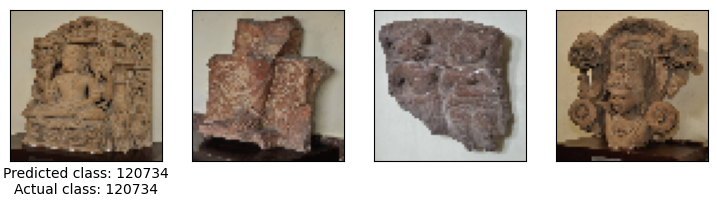

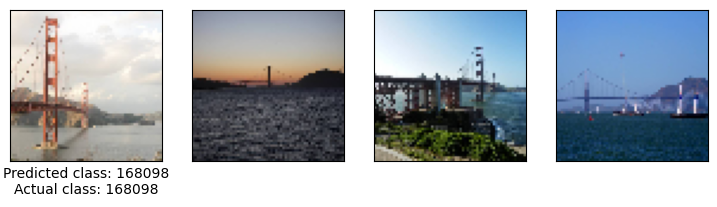

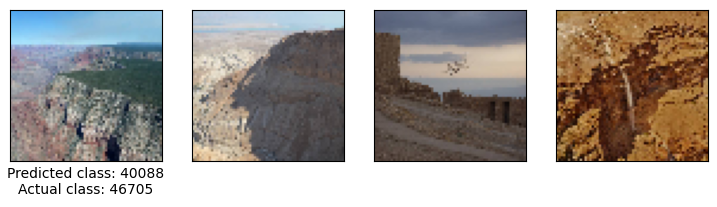

In [47]:
for k in range(3):
    plt.figure(figsize=(9,6))
    plt.subplot(1, 4, 1)
    img_pred = test_X[k]
    plt.xticks([])
    plt.yticks([])
    str1 = 'Predicted class: ' + str(pred_y[k])
    str3 = 'Actual class: ' + str(test_y[k])
    plt.xlabel(str1 + '\n' + str3)
    plt.imshow(img_pred)

    i=0
    img_class_df = subset_df[subset_df['landmark_id']==pred_y[k]]


    for i in range(len(img_class_df)):
        if i < (3):
            img_class_path = img_class_df.iloc[i,2]
            img_class = img_load(img_class_path)
            plt.subplot(1, 4, i+2)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(str())
            plt.imshow(img_class)
        else:
            break;